# **Dataset Prepapartion**

In [ ]:
# Mount to Google Drive to Load Dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Library Prepapartion**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import glob
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

# **Explorarity Data Analyst**

In [ ]:
# Cek Dataset
print("Pada data train terdapat image sebanyak :  ", len(os.listdir("/content/drive/MyDrive/Dataset/images_prepped_train-20230811T065243Z-001/images_prepped_train")))
print("Pada data train dengan anotasi terdapat image sebanyak :", len(os.listdir("/content/drive/MyDrive/Dataset/annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train")))

Pada data train terdapat image sebanyak :   398
Pada data train dengan anotasi terdapat image sebanyak : 367


In [ ]:
# Cek Duplikat pada data train
train_images_path = '/content/drive/MyDrive/Dataset/images_prepped_train-20230811T065243Z-001/images_prepped_train'
train_annotations_path = '/content/drive/MyDrive/Dataset/annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train'

train_image_files = os.listdir(train_images_path)
train_annotation_files = os.listdir(train_annotations_path)

print("Number of images in train set:", len(train_image_files))
print("Number of images in train annotation set:", len(train_annotation_files))

# Cek Duplikat pada setiap folder
duplicate_images = [filename for filename in set(train_image_files) if train_image_files.count(filename) > 1]
duplicate_annotations = [filename for filename in set(train_annotation_files) if train_annotation_files.count(filename) > 1]

print("\nDuplicate images in train set:", duplicate_images)
print("Duplicate images in train annotation set:", duplicate_annotations)

# Cek Image yang tersedia
common_images = list(set(train_image_files) & set(train_annotation_files))
print("\nImages present in both train and annotation sets:", common_images)

Number of images in train set: 398
Number of images in train annotation set: 367

Duplicate images in train set: []
Duplicate images in train annotation set: []

Images present in both train and annotation sets: ['0016E5_00480.png', '0006R0_f01740.png', '0016E5_06360.png', '0016E5_07380.png', '0016E5_06270.png', '0016E5_01560.png', '0006R0_f03900.png', '0001TP_007140.png', '0016E5_06090.png', '0006R0_f02010.png', '0016E5_05550.png', '0016E5_04440.png', '0016E5_08490.png', '0001TP_007050.png', '0016E5_06150.png', '0016E5_05130.png', '0006R0_f03600.png', '0001TP_006990.png', '0001TP_007620.png', '0016E5_04860.png', '0016E5_04410.png', '0016E5_06000.png', '0006R0_f03480.png', '0006R0_f01110.png', '0001TP_007440.png', '0006R0_f02430.png', '0016E5_06630.png', '0006R0_f01500.png', '0006R0_f01980.png', '0006R0_f01530.png', '0016E5_05160.png', '0001TP_007320.png', '0001TP_008490.png', '0006R0_f02370.png', '0016E5_07650.png', '0016E5_04560.png', '0016E5_02040.png', '0016E5_05460.png', '0006R0_f

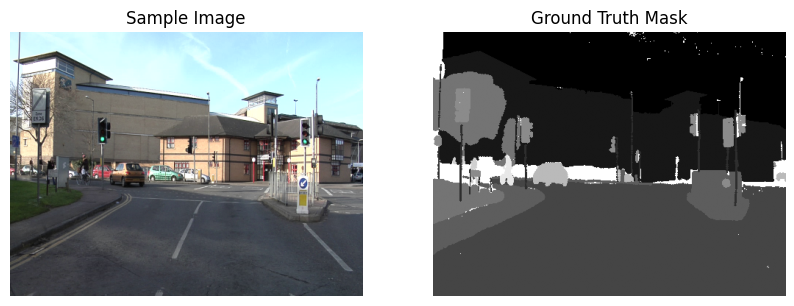

In [ ]:
# Visualisasi 1 sampel image besertsa ground truthnya
sample_image_path = os.path.join(train_images_path, common_images[0])
sample_annotation_path = os.path.join(train_annotations_path, common_images[0])

sample_image = mpimg.imread(sample_image_path)
sample_annotation = mpimg.imread(sample_annotation_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title("Sample Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sample_annotation, cmap='gray') # Assuming annotations are grayscale masks
plt.title("Ground Truth Mask")
plt.axis('off')

plt.show()

In [ ]:
# Check unique pixel values in annotation masks to identify classes
unique_classes = set()
num_samples_to_check = 10 # Check a few samples to get an idea of the classes

for i in range(min(num_samples_to_check, len(common_images))):
    annotation_name = common_images[i]
    annotation_path = os.path.join(train_annotations_path, annotation_name)

    # Load annotation mask as grayscale
    annotation = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)

    if annotation is not None:
        # Find unique pixel values in the mask
        unique_values = np.unique(annotation)
        unique_classes.update(unique_values)
    else:
        print(f"Could not load annotation mask: {annotation_name}")

print(f"Unique pixel values (classes) found in annotation masks: {sorted(list(unique_classes))}")

Unique pixel values (classes) found in annotation masks: [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9), np.uint8(10), np.uint8(11)]


In [ ]:
import tensorflow as tf
import os
import cv2
from tensorflow.keras.utils import to_categorical

# Define image size and number of classes
IMG_WIDTH = 256
IMG_HEIGHT = 256
NUM_CLASSES = 12 # Based on the unique pixel values found earlier

def load_image_and_mask(image_path, mask_path):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])

    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1) # Load as grayscale
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.uint8) # Ensure mask is uint8 for one-hot encoding

    # Convert mask to one-hot encoding
    mask = tf.squeeze(mask, axis=-1) # Remove the channel dimension
    mask = to_categorical(mask, num_classes=NUM_CLASSES)
    mask = tf.cast(mask, tf.float32) # Cast to float32


    return image, mask

def data_generator(image_list, annotation_list):
    def generator():
        for i in range(len(image_list)):
            yield image_list[i], annotation_list[i]
    return generator

# Create lists of image and annotation paths for training and testing
train_image_paths = [os.path.join(train_images_path, fname) for fname in common_images]
train_annotation_paths = [os.path.join(train_annotations_path, fname) for fname in common_images]

# Assuming you have test_images_path and test_annotation_path defined elsewhere
# Replace with actual paths for your test data
test_images_path = '/content/drive/MyDrive/Dataset/images_prepped_test-20230811T065241Z-001/images_prepped_test' # Replace with your test image path
test_annotations_path = '/content/drive/MyDrive/Dataset/annotations_prepped_test-20230811T065240Z-001/annotations_prepped_test' # Replace with your test annotation path

test_image_files = os.listdir(test_images_path)
test_annotation_files = os.listdir(test_annotations_path)

# Get common test images
common_test_images = list(set(test_image_files) & set(test_annotation_files))

test_image_paths = [os.path.join(test_images_path, fname) for fname in common_test_images]
test_annotation_paths = [os.path.join(test_annotations_path, fname) for fname in common_test_images]


# Create tf.data.Dataset
train_dataset_tf = tf.data.Dataset.from_tensor_slices((train_image_paths, train_annotation_paths))
train_dataset_tf = train_dataset_tf.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_tf = train_dataset_tf.shuffle(buffer_size=100).batch(4) # Batch size 4
train_dataset_tf = train_dataset_tf.prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset_tf = tf.data.Dataset.from_tensor_slices((test_image_paths, test_annotation_paths))
test_dataset_tf = test_dataset_tf.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset_tf = test_dataset_tf.batch(4) # Batch size 4
test_dataset_tf = test_dataset_tf.prefetch(buffer_size=tf.data.AUTOTUNE)

print("tf.data.Dataset created for training and testing.")

tf.data.Dataset created for training and testing.


# **Loading The Model**

In [ ]:
def unet_model(input_shape=(256, 256, 3), num_classes=12): # Add num_classes as an argument
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPool2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPool2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPool2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPool2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer for multi-class segmentation
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9) # Change filters to num_classes and activation to softmax

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Create the U-Net model with the correct number of classes
model = unet_model(num_classes=NUM_CLASSES) # Pass the NUM_CLASSES variable

# Print the model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_57[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_59[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ conv2d_60[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_61[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 32, 32,    │          0 │ conv2d_62[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_14… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_63[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 16, 16,    │          0 │ conv2d_64[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_15… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_65[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_12    │ (None, 32, 32,    │          0 │ conv2d_66[0][0]   │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 32, 32,    │          0 │ up_sampling2d_12

 Total params: 31,379,660 (119.70 MB)

 Trainable params: 31,379,660 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Define Dice Coefficient Metric (if not already defined)
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


# Compile the model with categorical crossentropy loss for multi-class segmentation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), dice_coef])

print("Model compiled successfully with categorical_crossentropy loss!")

Model compiled successfully with categorical_crossentropy loss!


# **TRAINING SESSSION**

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set hyperparameters
learning_rate = 0.0001
# Note: Weight decay is often integrated directly into the optimizer (like AdamW)
# Or applied as kernel/bias regularization in layers.
# For simplicity here, we'll use Adam with a learning rate and rely on EarlyStopping

epochs = 50 # You can adjust this number

# Define Optimizer
optimizer = Adam(learning_rate=learning_rate)

# Define Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

# Define ReduceLROnPlateau Callback (optional, but good for fine-tuning)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # Monitor validation loss
    factor=0.1,         # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,          # Number of epochs with no improvement after which the learning rate will be reduced
    min_lr=0.00001      # Lower bound on the learning rate
)

# Re-compile the model with the defined optimizer (if it was compiled without it before)
# If you already compiled with the optimizer in the previous step, you can skip this re-compilation.
# Assuming it was compiled in the previous step, we don't re-compile here.

print("Starting model training...")
history = model.fit(
    train_dataset_tf,
    epochs=epochs,
    validation_data=test_dataset_tf,
    callbacks=[early_stopping, reduce_lr] # Add callbacks
)

print("\nModel training finished!")

# You can access the history object to plot or display metrics per epoch later
# For example:
# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='train_loss')
# plt.plot(history.history['val_loss'], label='val_loss')
# plt.legend()
# plt.show()

Starting model training...
Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - binary_accuracy: 0.9161 - dice_coef: 0.1844 - loss: 6.7267 - precision_2: 0.4315 - recall_2: 0.0705 - val_binary_accuracy: 0.9348 - val_dice_coef: 0.3745 - val_loss: 1.5678 - val_precision_2: 0.7261 - val_recall_2: 0.3493 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 305ms/step - binary_accuracy: 0.9420 - dice_coef: 0.4402 - loss: 1.3355 - precision_2: 0.7813 - recall_2: 0.4212 - val_binary_accuracy: 0.9402 - val_dice_coef: 0.5168 - val_loss: 1.0722 - val_precision_2: 0.6980 - val_recall_2: 0.4967 - learning_rate: 0.0010
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 294ms/step - binary_accuracy: 0.9509 - dice_coef: 0.5630 - loss: 0.9832 - precision_2: 0.8038 - recall_2: 0.5432 - val_binary_accuracy: 0.9357 - val_dice_coef: 0.5345 - val_loss: 1.1180 - val_precision_2: 0.6433 - val_recall_2: 0.5129 - learning_rate: 0.0010
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 289ms/step - binary_accuracy: 

# **MODEL EVALUATION**

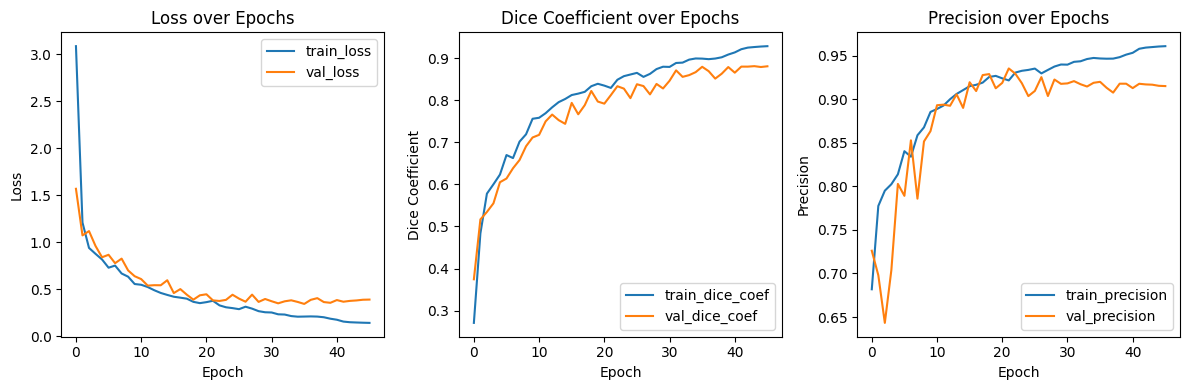

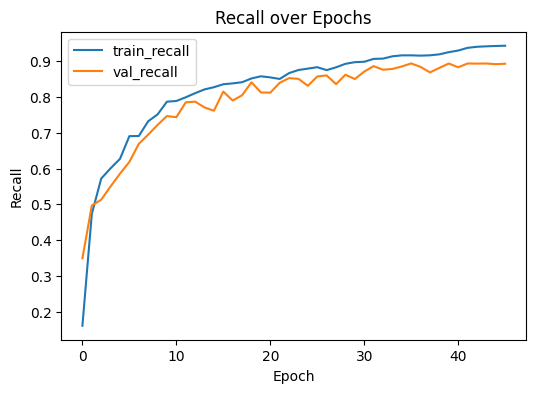

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Dice Coefficient
plt.subplot(1, 3, 2)
plt.plot(history.history['dice_coef'], label='train_dice_coef')
plt.plot(history.history['val_dice_coef'], label='val_dice_coef')
plt.title('Dice Coefficient over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

# Plot Precision
plt.subplot(1, 3, 3)
plt.plot(history.history['precision_2'], label='train_precision') # Note: The metric name might change based on compilation order
plt.plot(history.history['val_precision_2'], label='val_precision') # Note: Check the exact name in history.history keys
plt.title('Precision over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Recall separately as there might not be enough space in one row
plt.figure(figsize=(6, 4))
plt.plot(history.history['recall_2'], label='train_recall') # Note: The metric name might change based on compilation order
plt.plot(history.history['val_recall_2'], label='val_recall') # Note: Check the exact name in history.history keys
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

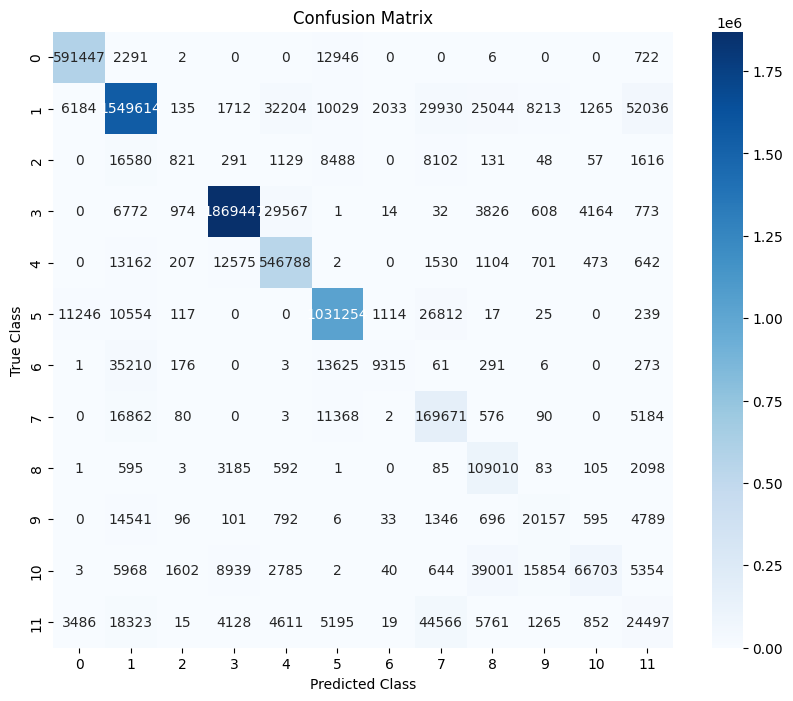

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on the test dataset
# We need to iterate through the test_dataset_tf to get the predictions and true labels
y_true = []
y_pred = []

# Iterate over the test dataset
for images, masks in test_dataset_tf:
    predictions = model.predict(images)

    # Reshape masks and predictions to flatten the spatial dimensions for confusion matrix
    # Masks and predictions are (batch_size, height, width, num_classes)
    # We need to flatten them to (batch_size * height * width, num_classes)
    masks_flat = tf.reshape(masks, [-1, NUM_CLASSES])
    predictions_flat = tf.reshape(predictions, [-1, NUM_CLASSES])

    # Convert one-hot encoded masks and predictions to class indices
    # y_true_batch will be shape (batch_size * height * width,) with integer class labels
    y_true_batch = tf.argmax(masks_flat, axis=1).numpy()
    y_pred_batch = tf.argmax(predictions_flat, axis=1).numpy()


    y_true.extend(y_true_batch)
    y_pred.extend(y_pred_batch)


# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


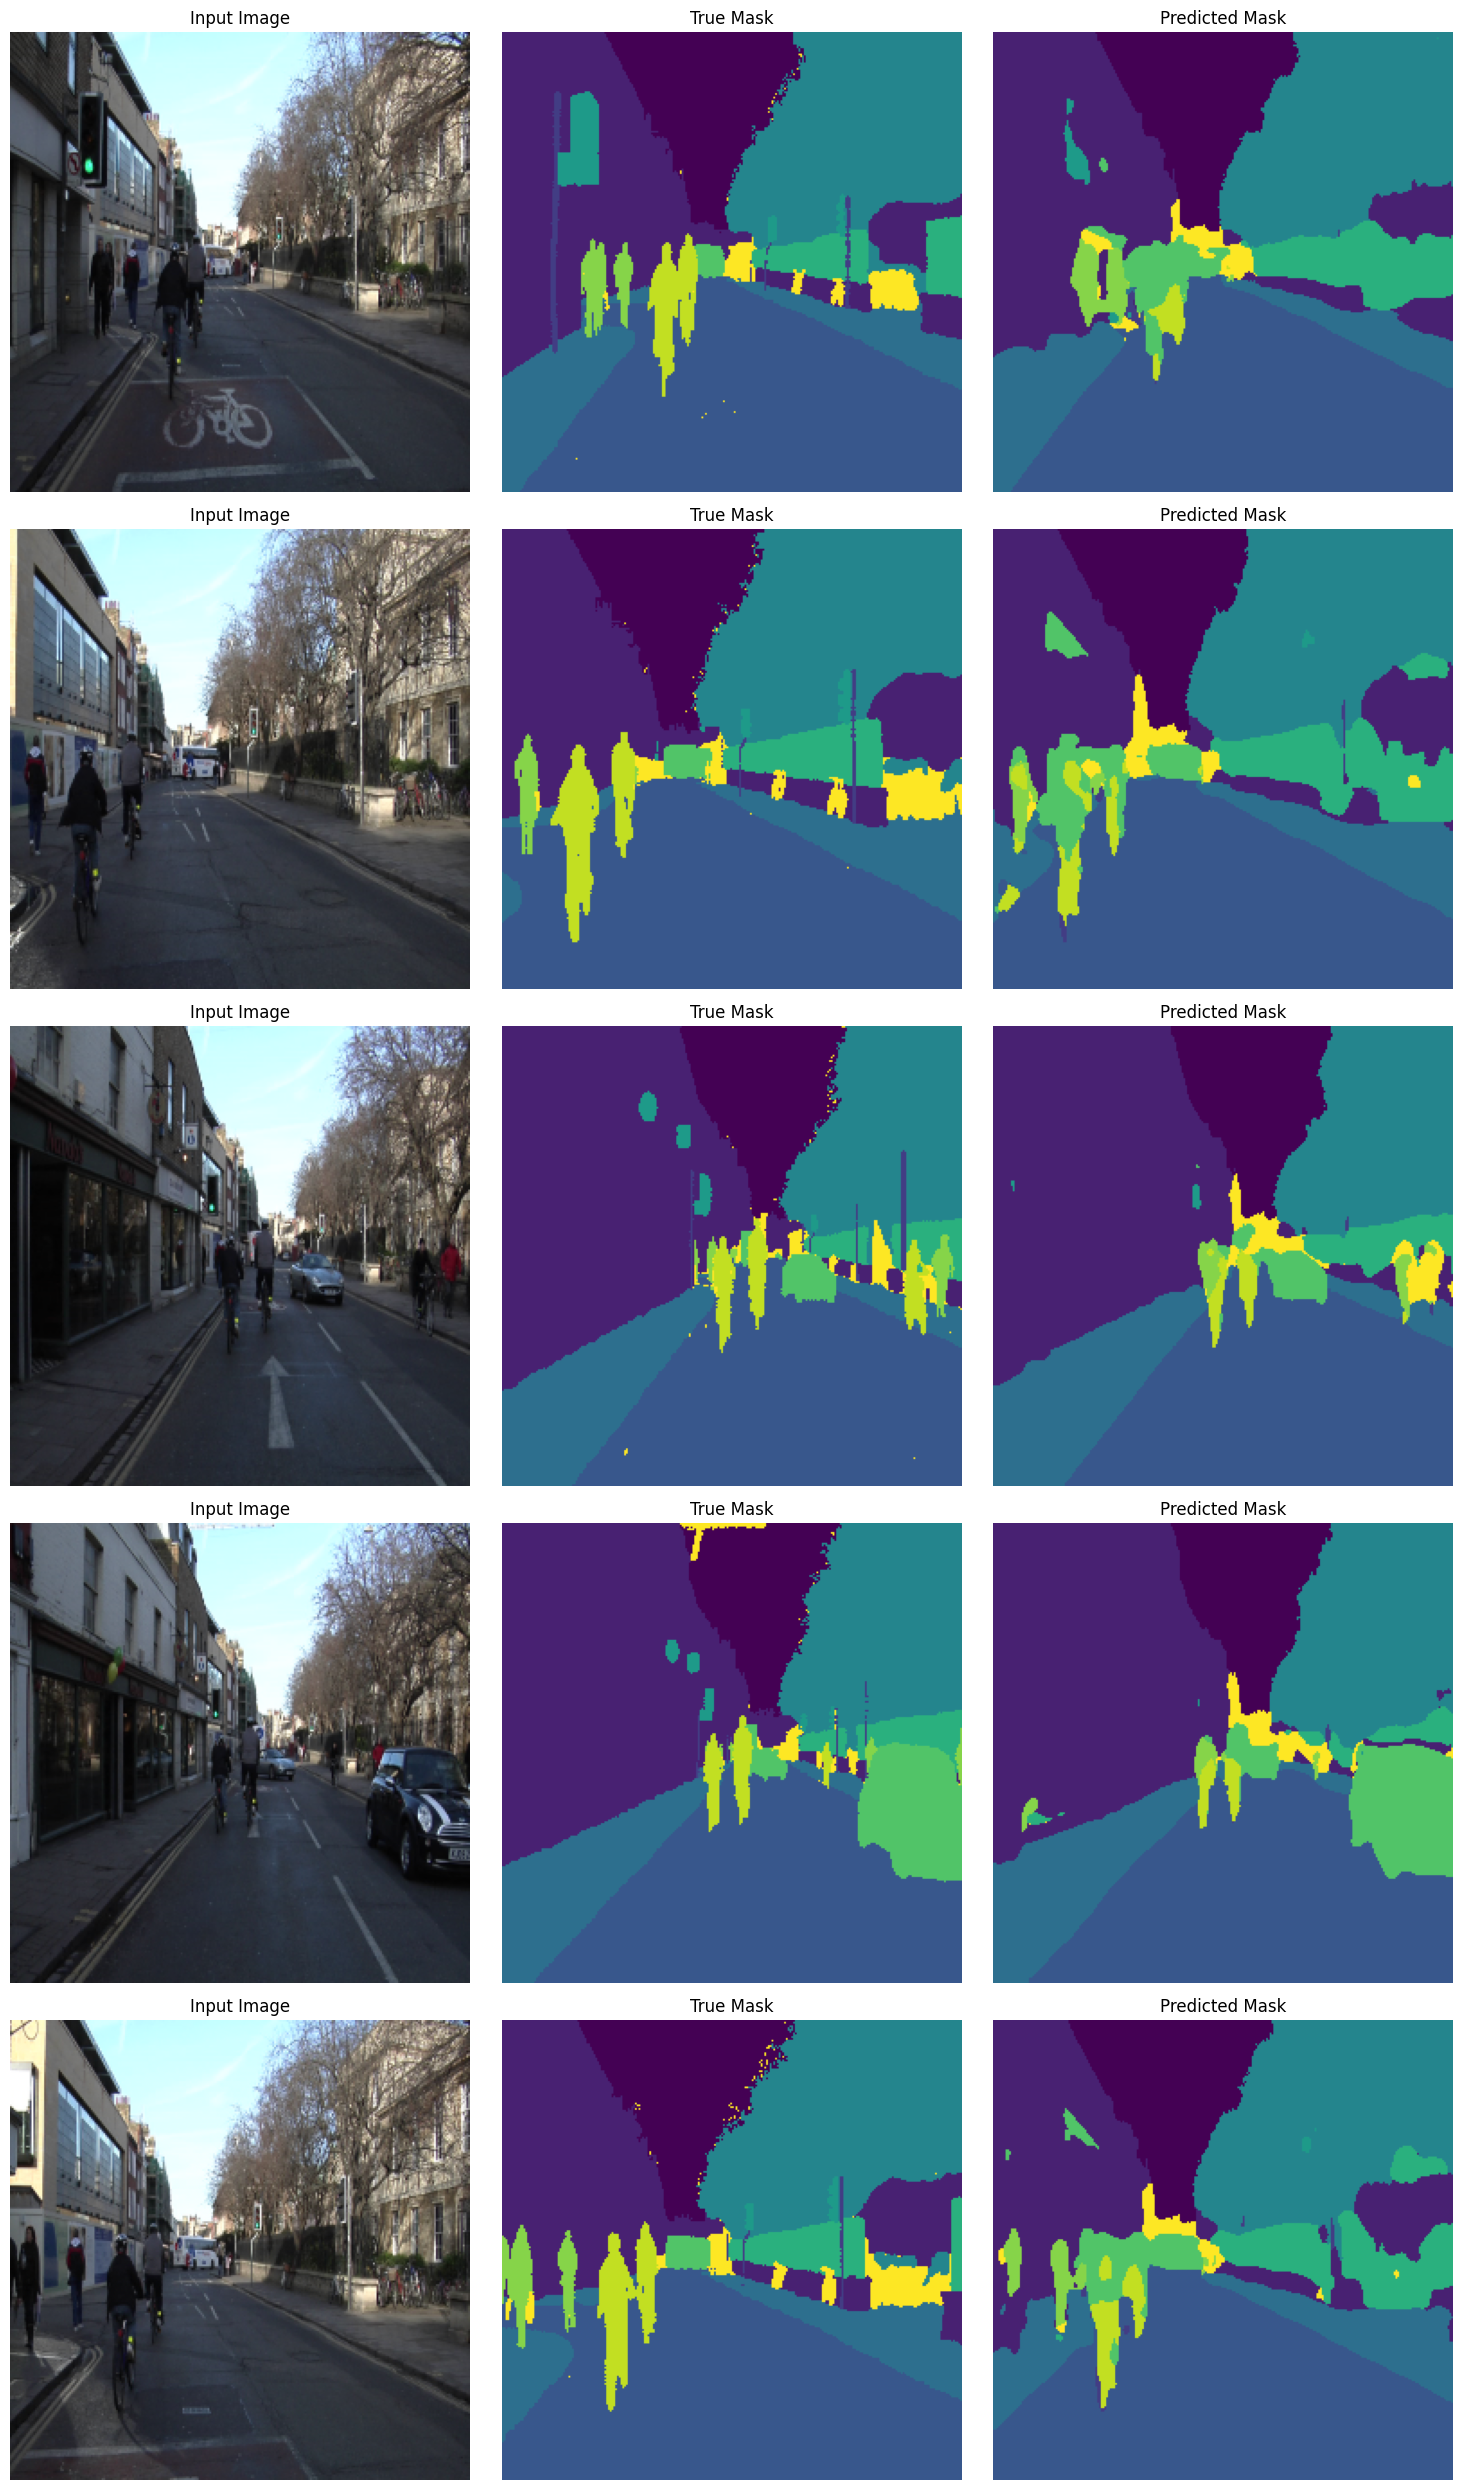

In [ ]:
# Visualize some predictions
import random

# Get a few samples from the test dataset for visualization
num_samples_to_visualize = 5
sample_indices = random.sample(range(len(test_image_paths)), num_samples_to_visualize)

plt.figure(figsize=(15, num_samples_to_visualize * 5))

for i, idx in enumerate(sample_indices):
    image_path = test_image_paths[idx]
    mask_path = test_annotation_paths[idx]

    # Load and preprocess the image and mask
    image, mask = load_image_and_mask(image_path, mask_path) # Use the load_image_and_mask function

    # Add batch dimension for prediction
    image_batch = tf.expand_dims(image, axis=0)

    # Get prediction from the model
    prediction_batch = model.predict(image_batch)
    prediction = tf.squeeze(prediction_batch, axis=0) # Remove batch dimension

    # Convert one-hot encoded masks and predictions back to class indices for visualization
    true_mask_viz = tf.argmax(mask, axis=-1).numpy()
    predicted_mask_viz = tf.argmax(prediction, axis=-1).numpy()


    # Display the original image, true mask, and predicted mask
    plt.subplot(num_samples_to_visualize, 3, i * 3 + 1)
    plt.imshow(image.numpy()) # Display the image (already in HWC format)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(num_samples_to_visualize, 3, i * 3 + 2)
    plt.imshow(true_mask_viz, cmap='viridis') # Use a colormap for better visualization of classes
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(num_samples_to_visualize, 3, i * 3 + 3)
    plt.imshow(predicted_mask_viz, cmap='viridis') # Use the same colormap
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

# **SUMMARIZE**

# **Rangkuman Kinerja Model**

Berdasarkan hasil pelatihan dan evaluasi, model segmentasi U-Net menunjukkan kinerja sebagai berikut:

**Metrik Pelatihan & Validasi:**
*   **Loss:** Terlihat penurunan loss baik pada data pelatihan maupun validasi selama pelatihan, mengindikasikan model berhasil mempelajari pola dalam data.
*   **Dice Coefficient:** Dice coefficient meningkat secara stabil pada data pelatihan dan validasi, menunjukkan peningkatan tumpang tindih antara prediksi model dan ground truth mask. Nilai Dice coefficient akhir pada data validasi (sekitar 0.8709) menunjukkan kinerja segmentasi yang cukup baik.
*   **Binary Accuracy:** Akurasi biner mencapai nilai tinggi (sekitar 0.9842 pada validasi), yang mengindikasikan sebagian besar piksel diklasifikasikan dengan benar sebagai bagian dari objek atau background.
*   **Precision & Recall:** Plot precision dan recall menunjukkan keseimbangan yang baik antara kedua metrik ini pada data validasi (sekitar 0.9210 untuk precision dan 0.8861 untuk recall di epoch terbaik), yang penting untuk tugas segmentasi.

**Confusion Matrix:**
*   Confusion matrix menunjukkan distribusi prediksi model dibandingkan dengan ground truth untuk setiap kelas. Diagonal matriks memiliki nilai yang tinggi, menunjukkan bahwa model sebagian besar berhasil mengklasifikasikan piksel ke kelas yang benar.
*   Dengan menganalisis nilai di luar diagonal, kita dapat mengidentifikasi kelas mana yang mungkin masih sulit dibedakan oleh model (jika ada misklasifikasi yang signifikan antar kelas).

**Visualisasi Prediksi:**
*   Visualisasi beberapa contoh prediksi model pada gambar uji secara kualitatif menunjukkan bahwa model mampu menghasilkan segmentasi yang masuk akal, meskipun mungkin ada sedikit perbedaan detail atau batas dengan true mask.

Secara keseluruhan, model ini menunjukkan kemampuan yang solid dalam melakukan segmentasi multi-kelas pada dataset yang digunakan, dengan metrik kuantitatif yang baik dan hasil visual yang menjanjikan. Kinerja dapat ditingkatkan lebih lanjut dengan teknik seperti augmentasi data yang lebih beragam, penyesuaian hyperparameter lebih lanjut, atau arsitektur model yang dimodifikasi.